In [39]:
import tensorflow as tf
import os
import glob
from matplotlib import pyplot as plt
import random
%matplotlib inline

In [40]:
# check for tensorflow config
print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


In [41]:
# create tensorboard log file
writer = tf.summary.create_file_writer("loss")

In [42]:
# get all train img path
imgs = glob.glob('../input/anime-sketch-colorization-pair/data/train/*.png')
# num of trian img
len(imgs)

14224

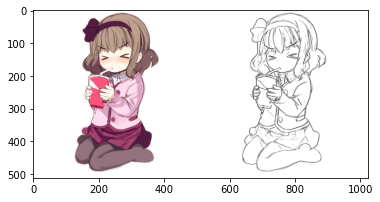

In [43]:
# random draw a img, we want to convert left half to right
plt.imshow(
    tf.keras.preprocessing.image.load_img(random.choice(imgs))
)
plt.show()

In [44]:
# normalize each color pixel with 8 bit(0-255) to -1 ~ +1
def normalize(image):
    image = (tf.cast(image, tf.float32)/255-0.5)*2
    return image

# read and split img to return (input,ans) pair
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    w = tf.shape(image)[1]  # img width
    w = int(w/2)  # the input and ans are in the right and left half
    
    # split input and ans
    input_ans = image[:, :w, :]
    input_image = image[:, w:, :]
    
    # convert to size 256*256
    input_ans = tf.image.resize(input_ans, (256, 256))
    input_image = tf.image.resize(input_image, (256, 256))
    
    return normalize(input_image), normalize(input_ans)

In [45]:
# load training img from path 
dataset = tf.data.Dataset.from_tensor_slices(imgs)
dataset = dataset.map(load_image)

In [46]:
# define batch size for training
BCTCH_SIZE = 32
BUFFER_SIZE = 200

In [47]:
# prepare training data set
dataset = dataset.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>


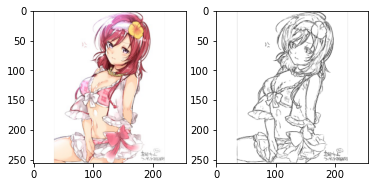

In [48]:
# plot a sample from training data set
for img, ans in dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(ans[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

In [49]:
# get all test img path
imgs_test = glob.glob('../input/anime-sketch-colorization-pair/data/val/*.png')

In [50]:
# load test img from path 
dataset_test = tf.data.Dataset.from_tensor_slices(imgs_test)
dataset_test = dataset_test.map(load_image)

In [51]:
# prepare test data set
dataset_test = dataset_test.batch(BCTCH_SIZE)
print(dataset_test)

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>


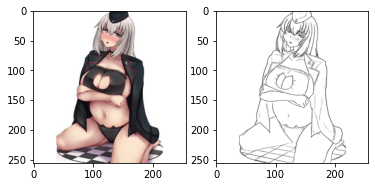

In [52]:
# plot a sample from test data set
for img, ans in dataset_test.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(ans[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

In [53]:
# import tf model and layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, Activation, Input, Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

In [54]:
# for down size conv layer
def down_step(filters, size, apply_bn=True):
    model = Sequential()
    model.add(Conv2D(filters, size, strides=2, padding='same', use_bias=False))
    
    if apply_bn:
        model.add(BatchNormalization())
    model.add(LeakyReLU())
    return model

In [55]:
# for up size deconv layer
def up_step(filters, size, apply_drop=False):
    model = Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    
    if apply_drop:
        model.add(Dropout(0.4))
    model.add(ReLU())
    return model

# for up size interporlation layer
def up_step_re_conv(filters, size, apply_drop=False):
    model = Sequential()
    model.add(UpSampling2D(size=(4, 4), interpolation='nearest'))
    model.add(Conv2D(filters, size, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    
    if apply_drop:
        model.add(Dropout(0.3))
    model.add(ReLU())
    return model

In [64]:
# define the generator for gan
def Generator():
    inputs = Input(shape=(256, 256, 3)) #256*256
    
    """down_stack = [
        down_step(64, (5,5), apply_bn=False),     #32 128*128
        down_step(128, (4,4)),                    #64 64*64
        down_step(128, (4,4)),                   #256 32*32
        down_step(256, (3,3)),                    #512 16*16
        down_step(256, (3,3)),                   #512 8*8
        down_step(512, (3,3)),                   #512 4*4
        down_step(512, (3,3)),                   #512 2*2
        down_step(512, (3,3)),                   #512 1*1
    ]
    
    up_stack = [
        up_step(512, (3,3), apply_drop=True),      #512 8*8
        up_step(512, (3,3), apply_drop=True),      #256 16*16
        up_step(256, (3,3), apply_drop=True),      #512 8*8
        up_step(256, (3,3)),                       #256 16*16
        up_step(128, (4,4)),                        #128 32*32
        up_step(128, (4,4)),                        #64 64*64
        up_step_re_conv(64, (5,5))                         #32 128*128
    ]
    
    x = inputs
    
    sendtoup = []     
    
    for d in down_stack:
        x = d(x)
        sendtoup.append(x)
        
    sendtoup = reversed(sendtoup[ :-1])
    
    for u, s in zip(up_stack, sendtoup):
        x = u(x)
        x = Concatenate()([x, s])"""
    # decoder
    d1 = down_step(64, (5,5), apply_bn=False)(inputs) #128*128
    d2 = down_step(128, (4,4))(d1) #64*64
    d3 = down_step(128, (4,4))(d2) #32*32
    d4 = down_step(256, (3,3))(d3) #16*16
    d5 = down_step(256, (3,3))(d4) #8*8
    d6 = down_step(512, (3,3))(d5) #4*4
    d7 = down_step(512, (3,3))(d6) #2*2
    d8 = down_step(512, (3,3))(d7) #1*1
    
    # encoder
    u1 = up_step(512, (3,3), apply_drop=True)(d8) #2*2
    c2 = Concatenate()([u1, d7])
    u3 = up_step(512, (3,3), apply_drop=True)(c2) #4*4
    c4 = Concatenate()([u3, d6])
    u5 = up_step(256, (3,3), apply_drop=True)(c4) #8*8
    c6 = Concatenate()([u5, d5])
    u7 = up_step(256, (3,3), apply_drop=True)(c6) #16*16
    c8 = Concatenate()([u7, d4])
    u9 = up_step(128, (3,3), apply_drop=True)(c8) #32*32
    c10 = Concatenate()([u9, d3])
    u11 = up_step(128, (3,3), apply_drop=True)(c10) #64*64
    c12 = Concatenate()([u11, d2])
    u13 = up_step_re_conv(64, (3,3), apply_drop=True)(c12) #128*128
    c14 = Concatenate()([u13, d1])
    
    x = UpSampling2D(size=(4, 4), interpolation='nearest')(c14) #512*512
    x = Conv2D(3, (2,2), strides=2, padding='same', use_bias=False, activation='tanh')(x) #256*256
    x = BatchNormalization()(x)
    
    #x = Conv2DTranspose(3, (2,2), strides=2,activation='tanh')(c14) #256*256
    return Model(inputs=inputs, outputs=x)

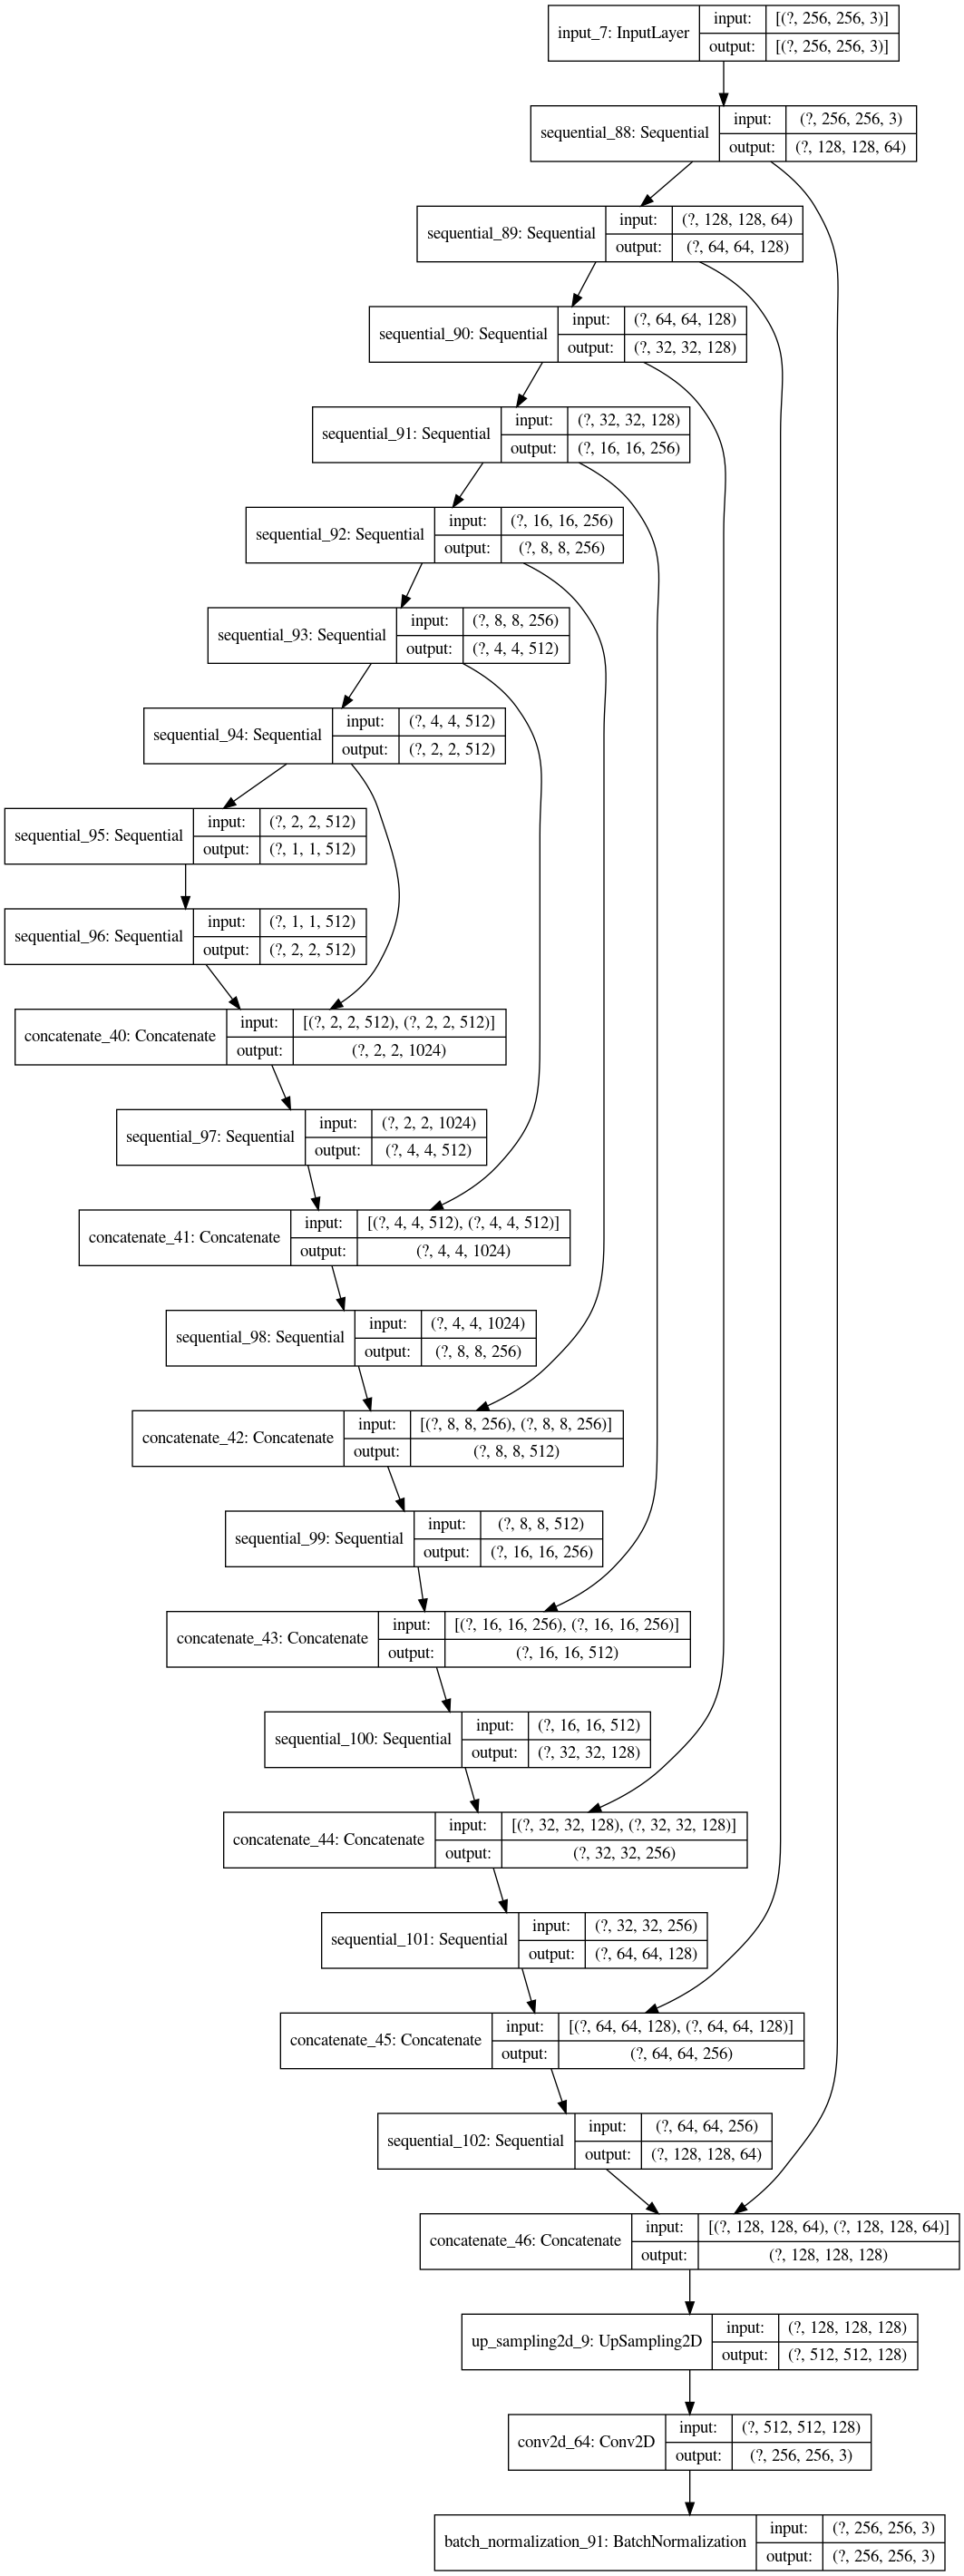

In [65]:
# build and show the generator
generator_C2S = Generator()
tf.keras.utils.plot_model(generator_C2S, to_file='generator.png',rankdir='TB', show_shapes=True)

In [66]:
# show info of generator
print(generator_C2S.summary())

Model: "functional_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_88 (Sequential)      (None, 128, 128, 64) 4800        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_89 (Sequential)      (None, 64, 64, 128)  131584      sequential_88[0][0]              
__________________________________________________________________________________________________
sequential_90 (Sequential)      (None, 32, 32, 128)  262656      sequential_89[0][0]              
_______________________________________________________________________________________

In [67]:
# define the discriminator for gan
def Disc():
    inp = tf.keras.layers.Input(shape=(256, 256, 3))
    tar = tf.keras.layers.Input(shape=(256, 256, 3))
    
    x = tf.keras.layers.concatenate([inp, tar]) #size=(256, 256, 6)
    
    x = down_step(128, (5,5), apply_bn=False)(x) #64 128*128
    x = down_step(256, (3,3))(x) #256 64*64
    x = down_step(256, (3,3))(x) #256 32*32
    x = tf.keras.layers.Conv2D(512, (3,3), strides=1, padding='same',use_bias=False)(x) #512 32*32
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(1, (3,3), strides=1)(x)   #1 30*30 featuremap
    
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

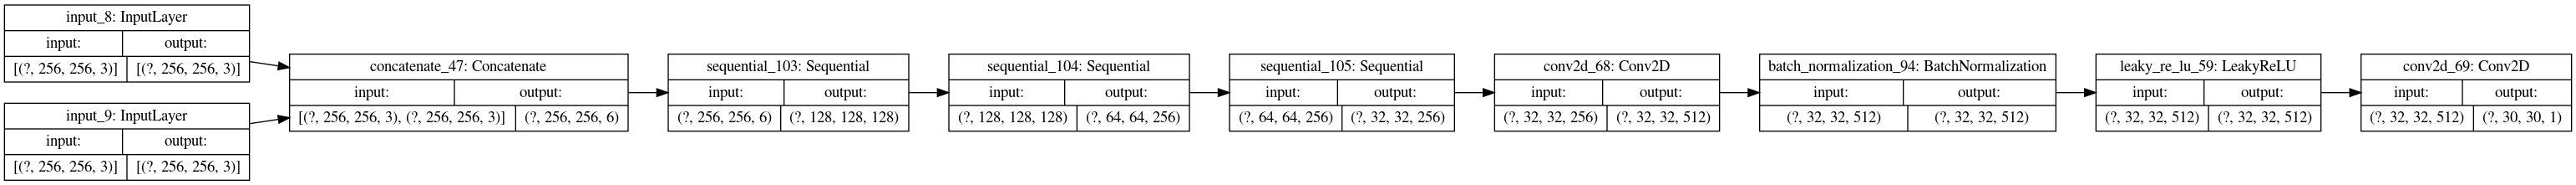

In [68]:
# build and show discriminator
discriminator_S = Disc()
tf.keras.utils.plot_model(discriminator_S, to_file='discriminator.png',rankdir='LR', show_shapes=True)

In [69]:
# show info of the discriminator
print(discriminator_S.summary())

Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_47 (Concatenate)    (None, 256, 256, 6)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
sequential_103 (Sequential)     (None, 128, 128, 128 19200       concatenate_47[0][0]  

In [70]:
LAMBDA = 10  # the bigger is more important for generator to learn the real image

# for generator loss
def gen_loss(generator_out_to_discriminator_out, generator_out, target):
    # generator out(fake) apply to discriminator and try to reach true(ones)
    gen_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(generator_out_to_discriminator_out), generator_out_to_discriminator_out, from_logits=True)
    # generator out(fake) compare to real image
    l1_loss = tf.reduce_mean(tf.abs(target - generator_out))
    
    return gen_loss, l1_loss,gen_loss + LAMBDA*l1_loss

# for generator loss using square
def gen_loss_ls(generator_out_to_discriminator_out, generator_out, target):
    # generator out(fake) apply to discriminator and try to reach true(ones)
    gen_loss =  tf.reduce_mean(tf.math.squared_difference(generator_out_to_discriminator_out, 1))
    # generator out(fake) compare to real image
    l1_loss = tf.reduce_mean(tf.abs(target - generator_out))
    
    return gen_loss, l1_loss,(gen_loss + LAMBDA*l1_loss)

#for discriminator loss
def disc_loss(real_to_discriminator_out, generator_out_to_discriminator_out):
    # real image apply to discriminator and try to reach true(ones)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_to_discriminator_out), real_to_discriminator_out, from_logits=True)
    # generator out(fake) apply to discriminator and try to reach false(ones)
    g_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generator_out_to_discriminator_out), generator_out_to_discriminator_out, from_logits=True)
    
    return real_loss + g_loss

#for discriminator loss using square
def disc_loss_ls(real_to_discriminator_out, generator_out_to_discriminator_out):
    # real image apply to discriminator and try to reach true(ones)
    real_loss =  tf.reduce_mean(tf.math.squared_difference(real_to_discriminator_out, 1))
    # generator out(fake) apply to discriminator and try to reach false(ones)
    g_loss =  tf.reduce_mean(tf.math.square(generator_out_to_discriminator_out))
    
    return (real_loss + g_loss)/2

# use generator to colorize from input sketch and draw the comparison
def show_predict_and_compare(model, input_img, target):
    prediction = model(input_img, training=True)
    plt.figure(figsize=(15,15))

    display = [input_img[0], target[0], prediction[0]]
    title = ['input', 'real', 'predict']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [71]:
# build the optimizer
generator_C2S_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_S_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [72]:
# define customized training step, this is called per batch
@tf.function
def train_step(input_image, target):
    sketch = input_image
    colored = target
    
    # compute loss
    with tf.GradientTape() as gen_C2S_tape, tf.GradientTape() as disc_S_tape:
        generator_C2S_output = generator_C2S(colored, training=True)#
        
        real_to_discriminator_S_out = discriminator_S([colored, sketch], training=True)#
        
        generator_C2S_out_to_discriminator_S_out = discriminator_S([colored, generator_C2S_output], training=True)#
        generator_C2S_g_loss, generator_C2S_l1_loss, generator_C2S_total_loss = gen_loss_ls(generator_C2S_out_to_discriminator_S_out, generator_C2S_output, sketch)#
        discriminator_S_total_loss = disc_loss_ls(real_to_discriminator_S_out, generator_C2S_out_to_discriminator_S_out)#
        
        l1_loss = generator_C2S_l1_loss
        
    # apply gradients to optimizer and refine model
    generator_C2S_gradients = gen_C2S_tape.gradient(generator_C2S_total_loss, generator_C2S.trainable_variables)#
    discriminator_S_gradients = disc_S_tape.gradient(discriminator_S_total_loss, discriminator_S.trainable_variables)#
    
    generator_C2S_optimizer.apply_gradients(zip(generator_C2S_gradients, generator_C2S.trainable_variables))#
    discriminator_S_optimizer.apply_gradients(zip(discriminator_S_gradients, discriminator_S.trainable_variables))#
    
    # return loss value for tracking                                                                                    
    return generator_C2S_g_loss, generator_C2S_total_loss, discriminator_S_total_loss, l1_loss

In [73]:
# train by a loop within 0~epochs and draw test result per 5 epochs
def fit(train, test, epochs):
    # train epochs 
    for epoch in range(0, epochs):
        print("epoch "+str(epoch)+":")
        
        # call customized train function per iteration in one epoch
        for img, ans in train:                                                          
            generator_C2S_g_loss, generator_C2S_total_loss, discriminator_S_total_loss, l1_loss=train_step(img, ans)
            print('.', end='')
        
        # track loss                                          
        with writer.as_default():
            tf.summary.scalar('generator_C2S_total_loss', tf.reduce_mean(generator_C2S_total_loss), step=epoch)#
            tf.summary.scalar('discriminator_S_total_loss', tf.reduce_mean(discriminator_S_total_loss), step=epoch)#
            tf.summary.scalar('generator_C2S_g_loss', tf.reduce_mean(generator_C2S_g_loss), step=epoch)#
            tf.summary.scalar('l1_loss', l1_loss, step=epoch)
        
        # draw test result 
        if epoch%5 == 0 or epoch == epochs-1:
            for img, ans in test.take(5):
                show_predict_and_compare(generator_C2S, img, ans)
        print()

In [74]:
# start training
EPOCHS = 50
fit(dataset, dataset_test, EPOCHS)

epoch 0:


ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/functional_4/conv2d_64/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_step_21986]

Function call stack:
train_step


In [ ]:
# save the model
generator_C2S.save('generator_C2S.h5')
discriminator_S.save('discriminator_S.h5')

In [ ]:
# show result in train data set
for example_input, example_target in dataset.take(25):
    show_predict_and_compare(generator_C2S, example_input, example_target)

In [ ]:
# show result in test data set
for example_input, example_target in dataset_test.take(25):
    show_predict_and_compare(generator_C2S, example_input, example_target)